In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
"""
Our Grid Object
"""
class Grid:
    def __init__(self,width,height,start):
        self.width = width
        self.height = height
        self.i = start[0] #vertical axis
        self.j = start[1] #horizontal axis
    
    def set(self,actions,rewards,obey_prob):
        self.actions = actions # dict:  (row,col): list of actions
        self.rewards = rewards # dict:  (row,col):  reward
        self.obey_prob = obey_prob
    
    def non_terminal_states(self):
        return self.actions.keys()
    
    def set_state(self,s):
        #change current stae
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return (self.i,self.j)
    
    def is_terminal(self,s):
        return s not in self.actions
    
    def stochastic_move(self, action):
        p = np.random.random()
        if p <= self.obey_prob:
            return action
        if action == 'U' or action == 'D':
            return np.random.choice(['L', 'R'])
        elif action == 'L' or action == 'R':
            return np.random.choice(['U', 'D'])
    
    def move(self,action):
        actual_action = self.stochastic_move(action)
        if actual_action in self.actions[(self.i, self.j)]:
            if actual_action == 'U':
                self.i -= 1
            elif actual_action == 'D':
                self.i += 1
            elif actual_action == 'R':
                self.j += 1
            elif actual_action == 'L':
                self.j -= 1
        return self.rewards.get((self.i, self.j), 0)
    
    def check_move(self,action):
        i = self.i
        j = self.j
        #check move validity
        if action in self.actions[(i,j)]:
            if action == "U":
                i-=1
            elif action == "D":
                i+=1
            elif action == "R":
                j+=1
            elif action == "L":
                j-=1
                
        reward = self.rewards.get((i,j),0)
        return ((i,j),reward)
    
    def get_transition_probs(self,action):
        # returns a list of (probability, reward, s') transition tuples
        probs = []
        state, reward = self.check_move(action)
        probs.append((self.obey_prob,reward,state))
        
        """
        if obey prob is 0.8
        and if action is 'up' then 
        'up' has probabiltiy of 0.8
        'left' has probability of 0.1
        'right' has probability of 0.1
        """
        disobey_prob = 1-self.obey_prob
        if disobey_prob <= 0:
            return probs
        if action == "U" or action == "D":
            state, reward = self.check_move("L")
            probs.append((disobey_prob/2,reward,state))
            state, reward = self.check_move("R")
            probs.append((disobey_prob/2,reward,state))
        elif action == "L" or action == "R":
            state, reward = self.check_move("U")
            probs.append((disobey_prob/2,reward,state))
            state,reward = self.check_move("D")
            probs.append((disobey_prob/2,reward,state))
        return probs
    
    def game_over(self):
        #return True if game is over else False
        #true if we are in state where no action are possible
        return (self.i,self.j) not in self.actions.keys()
    
    def all_states(self):
        # get all states
        # either a position that has possible next actions
        # or a position that yields a reward
        return set(self.actions.keys()) | set(self.rewards.keys())

In [3]:
"""
Initialization of Grid
"""
def standard_grid(obey_prob=0.1, step_cost = None):
    # lets define a grid that describes the reward for getting into each state
    # and possible actions at each state
    # the grid looks like this
    # x means you can't go there
    # s means start position
    # number means reward at that state
    # .  .  .  1
    # .  x  . -1
    # s  .  .  .
    # obey_brob (float): the probability of obeying the command
    # step_cost (float): a penalty applied each step to minimize the number of moves (-0.1)
    g = Grid(3, 4, (2, 0))
    
    rewards = {(0,3):+1, (1,3):-1}
    start = (2,0)
    actions = {
        (0,0) : ["R","D"],
        (0,1) : ["L","R"],
        (0,2) : ["L","D","R"],
        (1,0) : ["U","D"],
        (1,2) : ["U","D","R"],
        (2,0) : ["U","R"],
        (2,1) : ["L","R"],
        (2,2) : ["L","U","R"],
        (2,3) : ["L","U"]
    }
    
    g.set(actions,rewards,obey_prob)
    if step_cost is not None:
        g.rewards.update({
          (0, 0): step_cost,
          (0, 1): step_cost,
          (0, 2): step_cost,
          (1, 0): step_cost,
          (1, 2): step_cost,
          (2, 0): step_cost,
          (2, 1): step_cost,
          (2, 2): step_cost,
          (2, 3): step_cost,
        })
    return g

In [4]:
"""
Displaying Results
"""
def print_values(V, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") # -ve sign takes up an extra space
        print("")

def print_policy(P, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

In [5]:
GAMMA = 0.9
EPSILON = 0.2
ALL_POSSIBLE_ACTIONS = ["U","D","R","L"]
N_EPISODES = 10000

In [6]:
def epsilon_action(a,eps=0.1):
    p = np.random.random()
    if p < 1-eps:
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [7]:
def play_game(grid,policy):
    """return a list of states and corresponding returns (s,G)"""
    s = (2,0)
    grid.set_state(s)
    a = epsilon_action(policy[s],EPSILON)
    
    #reward is lagged by one time
    #r(t) results from a(t-1) in s(t-1) and landing in s(t)
    state_action_rewards = [(s,a,0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            state_action_rewards.append((s,None,r))
            break
        else:
            a = epsilon_action(a,EPSILON)
            state_action_rewards.append((s,a,r))
            
    #calculate returns by working backwards from terminal state
    G= 0 
    states_actions_returns = []
    first = True
    for s,a,r in reversed(state_action_rewards):
        # a terminal state has a value 0 by defination
        # this will be the first when we encounter reversed list
        # we will ignore its return G since it is not correspond to any one
        if first:
            first = False
        else:
            states_actions_returns.append((s,a,G))
        G = r + GAMMA*G
    states_actions_returns.reverse() # back to original order
    return states_actions_returns

In [8]:
def monte_carlo(grid):
    #initialize a random policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
    #initialize Q(s,a) and returns
    Q = {}
    visitCount = {}
    states = grid.non_terminal_states()
    for s in states:
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0
            visitCount[(s,a)] = 0
            
    deltas = [] # keep track of changes in Q values so we know our model converges
    for t in tqdm(range(N_EPISODES)):
        #generates episode using current policy
        biggest_change = 0
        states_action_returns = play_game(grid,policy)
        
        #calulate Q(s,a)
        seen_state_action_pairs = set()
        for s,a,G in states_action_returns:
            #check if we have already seen this state
            #first visit Monte Carlo Optimization
            sa = (s,a)
            if sa not in seen_state_action_pairs:
                visitCount[sa] += 1
                oldq = Q[s][a]
                #using incremental mean Uk = U(k-1) + 1/k (xk - U(k-1))
                #the new Q[s][a] is sample mean of all our returns for that (state,action)
                Q[s][a] = Q[s][a] + ( G - Q[s][a] )/visitCount[sa]
                biggest_change = max(biggest_change, abs(oldq -Q[s][a]))
                seen_state_action_pairs.add(sa)
        deltas.append(biggest_change)
        
    
        for s in policy.keys():
            best_a = None
            best_v = float('-inf')
            for a,v in Q[s].items():
                if v>best_v:
                    best_a = a
                    best_v = v
            policy[s] = best_a

    V = {}
    for s in policy.keys():
        best_v = float('-inf')
        for a,v in Q[s].items():
            if v>best_v:
                best_v = v
        V[s] = best_v
    return V,policy,deltas

100%|██████████| 10000/10000 [00:03<00:00, 3266.42it/s]


Final Values:
---------------------------
 0.61| 0.77| 1.00| 0.00|
---------------------------
 0.14| 0.00| 0.21| 0.00|
---------------------------
 0.11|-0.01| 0.12|-0.02|
Final Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |


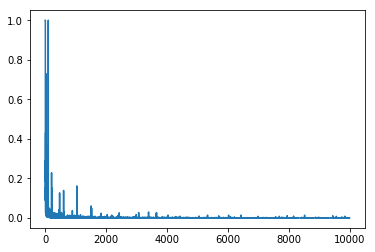

In [9]:
grid= standard_grid(obey_prob=1.0,step_cost=None)
V,policy,deltas = monte_carlo(grid)

print("Final Values:")
print_values(V,grid)

print("Final Policy:")
print_policy(policy,grid)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(deltas)
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3638.43it/s]


Final Values:
---------------------------
 0.42| 0.61| 0.82| 0.00|
---------------------------
 0.11| 0.00| 0.18| 0.00|
---------------------------
 0.07|-0.02| 0.01|-0.15|
Final Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  L  |


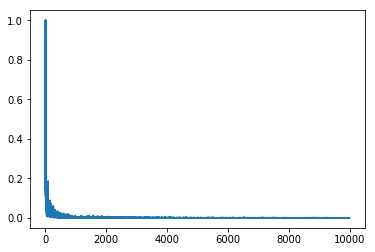

In [10]:
grid= standard_grid(obey_prob=.8,step_cost=None)
V,policy,deltas = monte_carlo(grid)

print("Final Values:")
print_values(V,grid)

print("Final Policy:")
print_policy(policy,grid)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(deltas)
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3337.58it/s]


Final Values:
---------------------------
 0.18| 0.34| 0.51| 0.00|
---------------------------
 0.09| 0.00|-0.05| 0.00|
---------------------------
 0.01|-0.03|-0.06|-0.22|
Final Policy:
---------------------------
  R  |  R  |  U  |     |
---------------------------
  U  |     |  L  |     |
---------------------------
  U  |  L  |  L  |  D  |


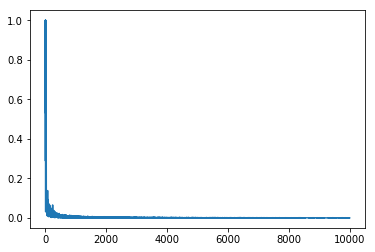

In [11]:
grid= standard_grid(obey_prob=0.5,step_cost=None)
V,policy,deltas = monte_carlo(grid)

print("Final Values:")
print_values(V,grid)

print("Final Policy:")
print_policy(policy,grid)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(deltas)
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3477.86it/s]


Final Values:
---------------------------
-0.44|-0.03| 0.37| 0.00|
---------------------------
-0.72| 0.00|-0.43| 0.00|
---------------------------
-0.80|-0.83|-0.72|-0.93|
Final Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  U  |


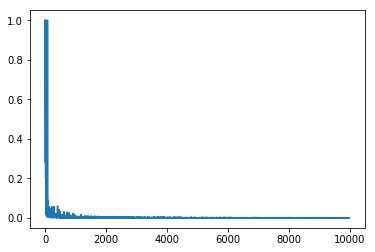

In [12]:
grid= standard_grid(obey_prob=0.5,step_cost=-0.1)
V,policy,deltas = monte_carlo(grid)

print("Final Values:")
print_values(V,grid)

print("Final Policy:")
print_policy(policy,grid)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(deltas)
plt.show()